# Exercise MNIST Image Classification with a CNN

## Introduction

In this exercise you will learn how to classify images of handwritten digits. For classification you will implement a CNN with pytorch.

In [1]:
# All necessary imports at the beginning
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import gzip
import urllib.request
import pandas as pd
import sklearn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

## Load, Explore and Prepare Dataset

The MNIST dataset is a classic Machine Learning dataset you can get it and more information about it from the website of [Yann Lecun](http://yann.lecun.com/exdb/mnist/). MNIST contains handwrittin digits and is split into a trainings set of 60000 examples and a test set of 10000 examples. You can use the module ```sklearn``` to load the MNIST dataset in a convenient way. 
easy load, mldata.org, orginal mnist, mnist link and description

**Note:**

If the cells below throws an error, the problem might be a broken download link. In that case, download the dataset from another source, e.g. from https://www.kaggle.com/avnishnish/mnist-original, and unzip it and place it under `BASE_DATA_DIR`.

In [3]:
BASE_DATA_DIR = os.path.expanduser('~/deep.TEACHING/data')

class Mnist:
    """Downloads, loads into numpy array and reshapes the common machine learning dataset: MNIST

    The MNIST dataset contains handwritten digits, available from http://yann.lecun.com/exdb/mnist/,
    has a training set of 60,000 examples, and a test set of 10,000 examples. With the class you can
    download the dataset and prepare them for usage, e.g., flatten the images or hot-encode the labels.
    """

    def __init__(self, data_dir=None, auto_download=True, verbose=True):
        """Downloads and moves MNIST dataset in a given folder.

        MNIST will be downloaded from http://yann.lecun.com/exdb/mnist/ and moved
        into the folder 'data_dir', if a path is given by the user, else files
        will be moved into a folder specified by the deep-teaching-commons
        config file.

        Args:
            data_dir: A string representing a path where you want to store MNIST.
            auto_download: A boolean, if True and the given 'data_dir' does not exists, MNIST will be download.
            verbose: A boolean indicating more user feedback or not.
        """
        self.data_dir = data_dir
        self.verbose = verbose

        if self.data_dir is None:
            self.data_dir = os.path.join(BASE_DATA_DIR, 'MNIST')

        self.data_url = 'http://yann.lecun.com/exdb/mnist/'
        self.files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']

        if auto_download:
            if self.verbose:
                print('auto download is active, attempting download')
            self.download()

    def download(self):
        """Downloads MNIST dataset.

        Creates a directory, downloads MNIST and moves the data into the
        directory. MNIST source and target directory are defined by
        class initialization (__init__).

        TODO:
            Maybe redesign so it can be used as standalone method.
        """
        if os.path.exists(self.data_dir):
            if self.verbose:
                print('mnist data directory already exists, download aborted')
        else:
            if self.verbose:
                print('data directory does not exist, starting download...')
            # Create directories
            os.makedirs(self.data_dir)
            # Download each file and move it to given self.data_dir
            for file in self.files:
                urllib.request.urlretrieve(self.data_url + file, file)
                shutil.move(file, os.path.join(self.data_dir, file))
                if self.verbose:
                        print(file,'successfully downloaded')
            if self.verbose:
                print('... mnist data completely downloaded, enjoy.')

    def get_all_data(self, one_hot_enc=None, flatten=True, normalized=None):
        """Loads MNIST dataset into four numpy arrays.

        Default setup will return training and test images in a flat resprensentaion,
        meaning each image is row of 28*28 (784) pixel values. Labels are encoded as
        digit between 0 and 9. You can change both representation using the arguments,
        e.g., to preserve the image dimensions.

        Args:
            one_hot_enc (boolean): Indicates if labels returned in standard (0-9) or one-hot-encoded form
            flatten (boolean): Images will be returned as vector (flatten) or as matrix
            normalized (boolean): Indicates if pixels (0-253) will be normalized

        Returns:
            train_data (ndarray): A matrix containing training images
            train_labels (ndarray): A vector containing training labels
            test_data (ndarray): A matrix containing test images
            test_labels (ndarray): A vector containing test labels
        """
        train_images = self.get_images(os.path.join(self.data_dir,self.files[0]))
        train_labels = self.get_labels(os.path.join(self.data_dir,self.files[1]))
        test_images = self.get_images(os.path.join(self.data_dir,self.files[2]))
        test_labels = self.get_labels(os.path.join(self.data_dir,self.files[3]))

        if one_hot_enc:
            train_labels, test_labels = [self.to_one_hot_enc(labels) for labels in (train_labels, test_labels)]

        if flatten is False:
            train_images, test_images = [images.reshape(-1,28,28) for images in (train_images, test_images)]

        if normalized:
            train_images, test_images = [images/np.float32(256) for images in (train_images, test_images)]

        return train_images.copy(), train_labels.copy(), test_images.copy(), test_labels.copy()

    def get_images(self, file_path):
        """Unzips, reads and reshapes image files.

        Args:
            file_path (string): mnist image data file

        Returns:
            ndarray: A matrix containing flatten images
        """
        with gzip.open(file_path, 'rb') as file:
            images = np.frombuffer(file.read(), np.uint8, offset=16)
        return images.reshape(-1, 28 * 28)

    def get_labels(self, file_path):
        """Unzips and read label file.

        Args:
            file_path (string): mnist label data file

        Returns:
            ndarray: A vector containing labels
        """
        with gzip.open(file_path, 'rb') as file:
            labels = np.frombuffer(file.read(), np.uint8, offset=8)
        return labels


    def to_one_hot_enc(self, labels):
        """Converts standard MNIST label representation into an one-hot-encoding.

        Converts labels into a one-hot-encoding representation. It is done by
        manipulating a one diagonal matrix with fancy indexing.

        Args:
            labels (ndarray): Array of mnist labels

        Returns:
            ndarray: A matrix containing a one-hot-encoded label each row

        Example:
            [2,9,0] --> [[0,0,1,0,0,0,0,0,0,0]
                         [0,0,0,0,0,0,0,0,0,1]
                         [1,0,0,0,0,0,0,0,0,0]]
        """
        return np.eye(10)[labels]


In [4]:
mnist = Mnist()
X_train_all, y_train_all, X_test, y_test = mnist.get_all_data(one_hot_enc=True, flatten=False)

auto download is active, attempting download
mnist data directory already exists, download aborted


In [6]:
X_train_all.shape, y_train_all.shape

((60000, 28, 28), (60000, 10))

label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


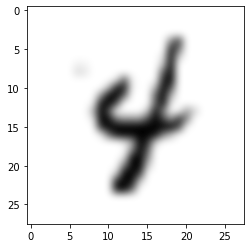

In [12]:
def plot_mnist_digit(digit):
    image = digit.reshape(28, 28)
    plt.imshow(image, cmap='binary', interpolation='bicubic')

#choose a random number, plot it and check label 
random_number = np.random.randint(1,len(X_train)-1)
print('label:', y_train[random_number]) 
plot_mnist_digit(X_train[random_number])

### Plot Digits

Let's plot more data. 


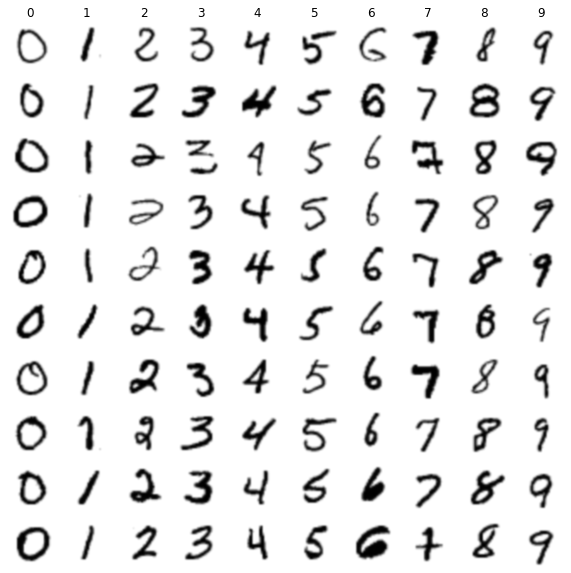

In [13]:
def plot_mnist_digits(X, y, examples_each_row):

    plt.figure(figsize=(10, 10))
    for c in range(10):    
        y_ = y_train.argmax(axis=1) # from one hot to indices        
        keys = np.random.choice((y_ == c).nonzero()[0], examples_each_row)
        images = X[keys]
    
        for i in range(examples_each_row):
            f = plt.subplot(examples_each_row, 10, i * 10 + c + 1)
            if i == 0:
                f.set_title(c)   
            f.axis('off')
            plt.imshow(images[i].reshape(28, 28), cmap='binary', interpolation='bicubic')
        
    plt.show()

    
plot_mnist_digits(X_train, y_train, examples_each_row=10)

## Exercises

### Task

- Write a simple CNN (similar to LeNet)
- Train the net and optimize hyperparameters (do not use the test set!)
- After tuning of the hyperparameters compute with your final model the accuracy of the test set. 

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

_Image Classification - CNN_ <br/>
by _Benjamin Voigt, Klaus Strohmenger, Christian Herta_ <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2020 _Benjamin Voigt, Klaus Strohmenger, Christian Herta_

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.